# Data preperation for Plots in rstudio

- Import libraries and functions

In [1]:
import numpy as np 
import pandas as pd
def merge_patusi(df1, df2):
    '''Merge on "patient unit stay id"'''
    
    return pd.merge(
        df1,
        df2,
        how='inner',
        on='patientunitstayid',
    )


- Import Datasets

In [3]:
apsvar = pd.read_csv('data/apacheApsVar.csv')
ascore_orig = pd.read_csv('data/apachePatientResult.csv')[
    ['patientunitstayid', 'apachescore']
].dropna()
admitsource = pd.read_csv(('data/apachePredVar.csv'))[
    ['patientunitstayid', 'admitsource']
]

- Add a column x_agegroup in patient data

In [ ]:
#!/bin/bash

path="${1:-.}"

sed <"$path/data/patient.csv" 's/,> 89,/,90,/' \
| awk '
    BEGIN {
      FS = ",";
      OFS = ",";
    }

    NR == 1 {
      // add header
      print $0, "x_agegroup";
    }

    NR > 1 {
      age = $4;

      if (age < 25)
        grp = "15-24";
      else if (age < 35)
        grp = "25-34";
      else if (age < 45)
        grp = "35-44";
      else if (age < 55)
        grp = "45-54";
      else if (age < 65)
        grp = "55-64";
      else if (age < 75)
        grp = "65-74";
      else if (age < 85)
        grp = "75-84";
      else
          grp = "85+";

      print $0, grp;
    }
' >"$path/data/patient_pp.csv"

In [4]:
patient_data= pd.read_csv('data/patient_pp.csv')[
    ['patientunitstayid',
     'unitdischargestatus',
     'gender',
     'ethnicity',
     'unitvisitnumber',
     'x_agegroup']
]

- Preprocessing ApacheApsVar.csv
- Replace the missing values by the mode of each column

In [5]:
Columns = apsvar.columns
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=-1,
                    strategy='most_frequent')
apsvar_mode=pd.DataFrame(
    data=imp.fit_transform(apsvar),
    columns=Columns)

- Save the data into csv file

In [6]:
apsvar_mode.to_csv('data/apacheApsVar_mode.csv', index=False)

- Preprocessing ApacheScore

In [43]:
# ascore.patientunitstayid.sort_values()
for grp, tbl in ascore_orig.groupby('patientunitstayid'):
    assert len(tbl.apachescore.unique()) == 1
ascore = ascore_orig.drop_duplicates('patientunitstayid')

- Save the data into csv file

In [44]:
ascore.to_csv('data/ascore.csv', index = False)

- Merge Data based on patientunitstayid

In [9]:
plots_in_r = (merge_patusi(merge_patusi(ascore,admitsource),patient_data)).dropna()

- Remove -1 from APACHE score
- Remove -1 from admitsource

In [10]:
plots_in_r = plots_in_r[
    plots_in_r.apachescore != -1
]
plots_in_r= plots_in_r[
    plots_in_r.admitsource != -1
]

- Change names: 
- Admit sources
- Unit visit numbers

In [11]:
names=["Operating Room",
       "Recovery Room",
       "Chest Pain Center",
       "Floor/Step-Down Unit (SDU)",
       "Other ICU",
       "Other Hospital",
       "Direct Admit",
       "Emergency Department"]

plots_in_r['Admitsource']=[names[F-1] for F in plots_in_r.admitsource ]
names = ['1','2 or more']
L = []
for i in plots_in_r.unitvisitnumber:
    if i==1:
        L.append(names[0])
    else :
        L.append(names[1])
plots_in_r['Unitvisitnumber_cat']=L        
plots_in_r=plots_in_r.drop(columns=['admitsource'])

- Save the data into csv file

In [12]:
plots_in_r.to_csv('data/plots_in_r.csv', index=False)

- The plots will be carried out in rstudio

# t-SNE algorithm
## Procedure
- Import Libraries
- Load the data we want to apply t-SNE on
- Run t-SNE
- Save the data

In [13]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

In [14]:
apsVar_mode=pd.read_csv('data/apacheApsVar_mode.csv').drop(columns=[
        'apacheapsvarid',
    
    #'fio2', 'pco2', 'pao2', 'ph', 'bilirubin', 'albumin', 'urine', ###### Nothing removed
    #'wbc','hematocrit', 'bun', 'creatinine', 'sodium', ##### Over 26 missing value
    #'glucose', ##### Over 14 missing value
])

- Run t-SNE algorithm 
- Assign Preplexity between 5 to 50. Here 50.
- For larger dataset , bigger number

In [ ]:
tsne=TSNE(perplexity=50)
%time tsne_apsVar_mdoe=tsne.fit_transform(
    apsVar_mode.drop(
        columns=['patientunitstayid']
    )
)

- Conver the data from the t-SNE into DataFrame and save in csv

In [ ]:
tsne_apsVar_mdoe=pd.DataFrame(data=tsne_apsVar_mdoe,columns=['x','y'])
tsne_apsVar_mdoe.to_csv('data/apsVarmode_nothing_removed_pp50.csv',index=False)

## Plot the data from t-SNE 
### Procedure
- Load the data from t-SNE with columns x,y
- Add patientunitstayid to this dataframe
- Merge the data with Expired/Alive(patient) and plot
- Merge the data with Apache Score(patient) and plot

In [37]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [45]:
tsne_data=pd.read_csv('data/apsVarmode_nothing_removed_pp50.csv')
apsVarmode=pd.read_csv('data/apacheApsVar_mode.csv')
ascore = pd.read_csv('data/ascore.csv')

- Append the patientunitstayid

In [46]:
tsne_data['patientunitstayid']=apsVarmode.patientunitstayid

- Add unitdischargestatus and APACHE score to the data

In [47]:
patient_uds=pd.read_csv('data/patient_pp.csv')[
    ['patientunitstayid','unitdischargestatus']
]

In [48]:
tsne_data_ascore_uds=merge_patusi(merge_patusi(tsne_data,ascore),patient_uds)

- Sort with respect to expired patients
- The reason is the small number of the expired patients compared to alive patients
- We want to plot them in away, that if 2 points mapped above together, we do not miss the expired patients data

In [50]:
tsne_data_ascore_uds=(
    tsne_data_ascore_uds.sort_values(by='unitdischargestatus')
).dropna()

In [51]:
len(tsne_data_ascore_uds)

148522

## Plot tsne-ascore

In [52]:
tsne_data_ascore = tsne_data_ascore_uds[
    tsne_data_ascore_uds.apachescore !=-1
]

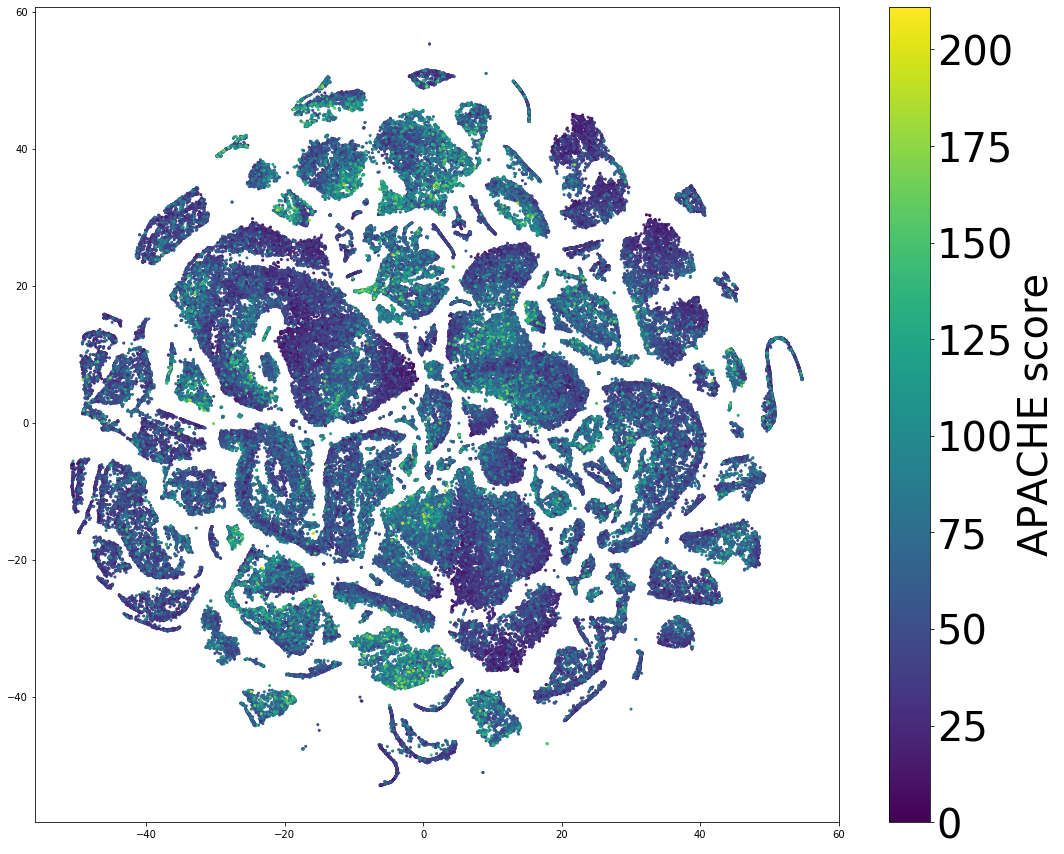

In [53]:
fig, ax=plt.subplots(figsize=(18,15))
cm=plt.cm.get_cmap('viridis')
im = ax.scatter(tsne_data_ascore.x,tsne_data_ascore.y,c=tsne_data_ascore.apachescore,cmap=cm,s=4)
cb=fig.colorbar(im, ax=ax)
cb.set_label(label='APACHE score', size=40)#weight='bold'
cb.ax.tick_params(labelsize=40)
plt.show()

## Plot tsne_patient_uds

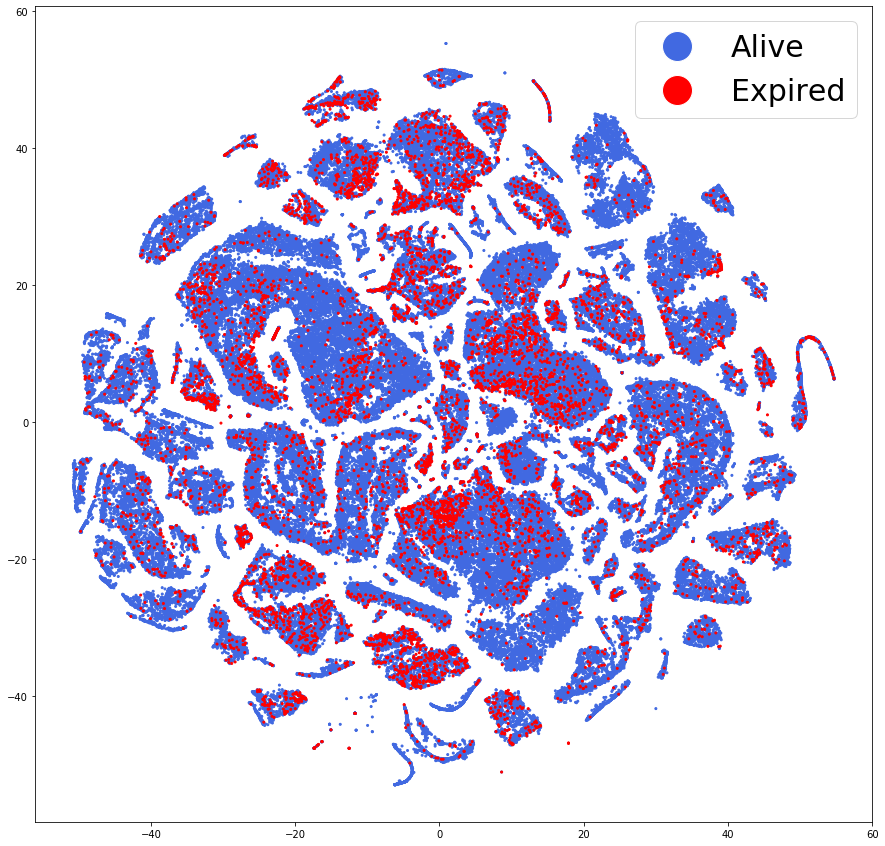

In [54]:
fig, ax=plt.subplots(figsize=(15,15))
color = [
    'red' if s == 'Expired' else 'royalblue'
    for s in tsne_data_ascore_uds['unitdischargestatus']
]
im = ax.scatter(tsne_data_ascore_uds.x,tsne_data_ascore_uds.y,c=color,s=4)
ax.legend(handles=[
   Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue',markersize=30, label='Alive'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='red' ,markersize=30,label='Expired'),
                  ],
          loc='upper right', fontsize=30
)


plt.show()